In [ ]:
#%reset

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

## data acquisition

In [ ]:
# 1 May-30 Jun
#df = pd.read_excel(r'monthly_2025_5-6.xlsx')

# 1-30 Jun
df = pd.read_excel(r'monthly.xlsx')

In [3]:
df

,Chart,Unnamed: 1,Unnamed: 2
0,DateTime,Solar,MEA
1,2025-06-01 10:45:00,388,0
2,2025-06-01 11:00:00,478,0
3,2025-06-01 11:15:00,767,0
4,2025-06-01 11:30:00,1019,0
...,...,...,...
2156,2025-06-30 22:00:00,0,695
2157,2025-06-30 22:30:00,0,681
2158,2025-06-30 22:45:00,0,647
2159,2025-06-30 23:15:00,0,589


In [4]:
df.columns = df.iloc[0]; df=df[1:].copy()
df

,DateTime,Solar,MEA
1,2025-06-01 10:45:00,388,0
2,2025-06-01 11:00:00,478,0
3,2025-06-01 11:15:00,767,0
4,2025-06-01 11:30:00,1019,0
5,2025-06-01 11:45:00,651,0
...,...,...,...
2156,2025-06-30 22:00:00,0,695
2157,2025-06-30 22:30:00,0,681
2158,2025-06-30 22:45:00,0,647
2159,2025-06-30 23:15:00,0,589


In [5]:
# Convert DateTime column to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

df['Solar'] = pd.to_numeric(df['Solar'], errors='coerce')
df['MEA'] = pd.to_numeric(df['MEA'], errors='coerce')

df['Energy'] = df['Solar']+df['MEA']
df

,DateTime,Solar,MEA,Energy
1,2025-06-01 10:45:00,388.0,0,388.0
2,2025-06-01 11:00:00,478.0,0,478.0
3,2025-06-01 11:15:00,767.0,0,767.0
4,2025-06-01 11:30:00,1019.0,0,1019.0
5,2025-06-01 11:45:00,651.0,0,651.0
...,...,...,...,...
2156,2025-06-30 22:00:00,0.0,695,695.0
2157,2025-06-30 22:30:00,0.0,681,681.0
2158,2025-06-30 22:45:00,0.0,647,647.0
2159,2025-06-30 23:15:00,0.0,589,589.0


In [6]:
df.dtypes

0
DateTime    datetime64[ns]
Solar              float64
MEA                  int64
Energy             float64
dtype: object

[Period Aliases](https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases)

In [7]:
df['DateTime'].dt.to_period('M')

1       2025-06
2       2025-06
3       2025-06
4       2025-06
5       2025-06
         ...   
2156    2025-06
2157    2025-06
2158    2025-06
2159    2025-06
2160    2025-06
Name: DateTime, Length: 2160, dtype: period[M]

In [8]:
# Extract unique year-month pairs from the data
df['YearMonth'] = df['DateTime'].dt.to_period('M')
unique_months = df['YearMonth'].unique()

In [9]:
unique_months

<PeriodArray>
['2025-06']
Length: 1, dtype: period[M]

In [10]:
# Generate complete 15-minute time slots for each month
full_times = []
for ym in unique_months:
    year = ym.year
    month = ym.month
    start_date = pd.Timestamp(f"{year}-{month:02d}-01 00:00:00")
    end_date = start_date + pd.offsets.MonthEnd(0) + pd.Timedelta(hours=23, minutes=45)
    full_times.extend(pd.date_range(start=start_date, end=end_date, freq='15min'))

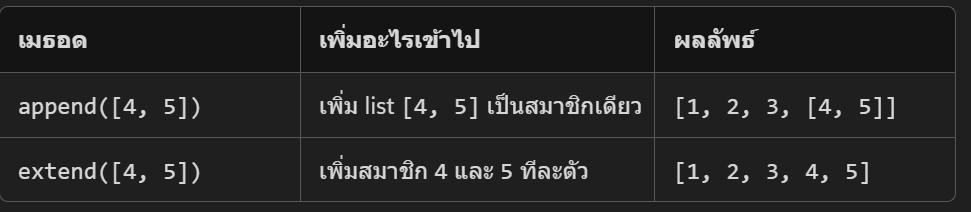

In [11]:
full_times

[Timestamp('2025-06-01 00:00:00'),
 Timestamp('2025-06-01 00:15:00'),
 Timestamp('2025-06-01 00:30:00'),
 Timestamp('2025-06-01 00:45:00'),
 Timestamp('2025-06-01 01:00:00'),
 Timestamp('2025-06-01 01:15:00'),
 Timestamp('2025-06-01 01:30:00'),
 Timestamp('2025-06-01 01:45:00'),
 Timestamp('2025-06-01 02:00:00'),
 Timestamp('2025-06-01 02:15:00'),
 Timestamp('2025-06-01 02:30:00'),
 Timestamp('2025-06-01 02:45:00'),
 Timestamp('2025-06-01 03:00:00'),
 Timestamp('2025-06-01 03:15:00'),
 Timestamp('2025-06-01 03:30:00'),
 Timestamp('2025-06-01 03:45:00'),
 Timestamp('2025-06-01 04:00:00'),
 Timestamp('2025-06-01 04:15:00'),
 Timestamp('2025-06-01 04:30:00'),
 Timestamp('2025-06-01 04:45:00'),
 Timestamp('2025-06-01 05:00:00'),
 Timestamp('2025-06-01 05:15:00'),
 Timestamp('2025-06-01 05:30:00'),
 Timestamp('2025-06-01 05:45:00'),
 Timestamp('2025-06-01 06:00:00'),
 Timestamp('2025-06-01 06:15:00'),
 Timestamp('2025-06-01 06:30:00'),
 Timestamp('2025-06-01 06:45:00'),
 Timestamp('2025-06-

In [12]:
pd.Timestamp(f"{year}-{month:02d}-01 00:00:00")

Timestamp('2025-06-01 00:00:00')

In [13]:
pd.date_range(start=start_date, end=end_date, freq='15min')

DatetimeIndex(['2025-06-01 00:00:00', '2025-06-01 00:15:00',
               '2025-06-01 00:30:00', '2025-06-01 00:45:00',
               '2025-06-01 01:00:00', '2025-06-01 01:15:00',
               '2025-06-01 01:30:00', '2025-06-01 01:45:00',
               '2025-06-01 02:00:00', '2025-06-01 02:15:00',
               ...
               '2025-06-30 21:30:00', '2025-06-30 21:45:00',
               '2025-06-30 22:00:00', '2025-06-30 22:15:00',
               '2025-06-30 22:30:00', '2025-06-30 22:45:00',
               '2025-06-30 23:00:00', '2025-06-30 23:15:00',
               '2025-06-30 23:30:00', '2025-06-30 23:45:00'],
              dtype='datetime64[ns]', length=2880, freq='15min')

In [14]:
full_times[:10]

[Timestamp('2025-06-01 00:00:00'),
 Timestamp('2025-06-01 00:15:00'),
 Timestamp('2025-06-01 00:30:00'),
 Timestamp('2025-06-01 00:45:00'),
 Timestamp('2025-06-01 01:00:00'),
 Timestamp('2025-06-01 01:15:00'),
 Timestamp('2025-06-01 01:30:00'),
 Timestamp('2025-06-01 01:45:00'),
 Timestamp('2025-06-01 02:00:00'),
 Timestamp('2025-06-01 02:15:00')]

In [15]:
# Define the start and end date for June 2025
start_date = "2025-06-01 00:00:00"
end_date = "2025-06-30 23:45:00"

# Create a date range with 15-minute intervals
date_range = pd.date_range(start=start_date, end=end_date, freq='15T')

# Create a DataFrame with the DateTime column
df_timeslots = pd.DataFrame({'DateTime': date_range})

# Display the first few rows to confirm
print(df_timeslots.head())
print(f"\nTotal time slots generated: {len(df_timeslots)}")

             DateTime
0 2025-06-01 00:00:00
1 2025-06-01 00:15:00
2 2025-06-01 00:30:00
3 2025-06-01 00:45:00
4 2025-06-01 01:00:00

Total time slots generated: 2880


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11360\1410232617.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='15T')


In [16]:
# Create a DataFrame with all time slots
df_full = pd.DataFrame({'DateTime': full_times})

# Merge with original data
df_merged = pd.merge(df_full, df[['DateTime', 'Solar', 'MEA', 'Energy']], on='DateTime', how='left')

# Display the merged DataFrame
df_merged


,DateTime,Solar,MEA,Energy
0,2025-06-01 00:00:00,NaN,NaN,NaN
1,2025-06-01 00:15:00,NaN,NaN,NaN
2,2025-06-01 00:30:00,NaN,NaN,NaN
3,2025-06-01 00:45:00,NaN,NaN,NaN
4,2025-06-01 01:00:00,NaN,NaN,NaN
...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0
2876,2025-06-30 23:00:00,NaN,NaN,NaN
2877,2025-06-30 23:15:00,0.0,589.0,589.0
2878,2025-06-30 23:30:00,0.0,619.0,619.0


In [17]:
# สร้าง feature ใหม่
df_merged['is_wfh'] = (df_merged['DateTime'].dt.weekday == 2).astype(int)  # วันพุธ
df_merged['is_weekend'] = (df_merged['DateTime'].dt.weekday >= 5).astype(int)  # วันเสาร์-อาทิตย์

# สร้าง list ของวันหยุด
holidays = [
    pd.to_datetime('2025-06-03')
]

# สร้าง feature is_holiday
df_merged['is_holiday'] = df_merged['DateTime'].dt.date.isin([d.date() for d in holidays]).astype(int)
df_merged

,DateTime,Solar,MEA,Energy,is_wfh,is_weekend,is_holiday
0,2025-06-01 00:00:00,NaN,NaN,NaN,0,1,0
1,2025-06-01 00:15:00,NaN,NaN,NaN,0,1,0
2,2025-06-01 00:30:00,NaN,NaN,NaN,0,1,0
3,2025-06-01 00:45:00,NaN,NaN,NaN,0,1,0
4,2025-06-01 01:00:00,NaN,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0,0,0,0
2876,2025-06-30 23:00:00,NaN,NaN,NaN,0,0,0
2877,2025-06-30 23:15:00,0.0,589.0,589.0,0,0,0
2878,2025-06-30 23:30:00,0.0,619.0,619.0,0,0,0


<Axes: >

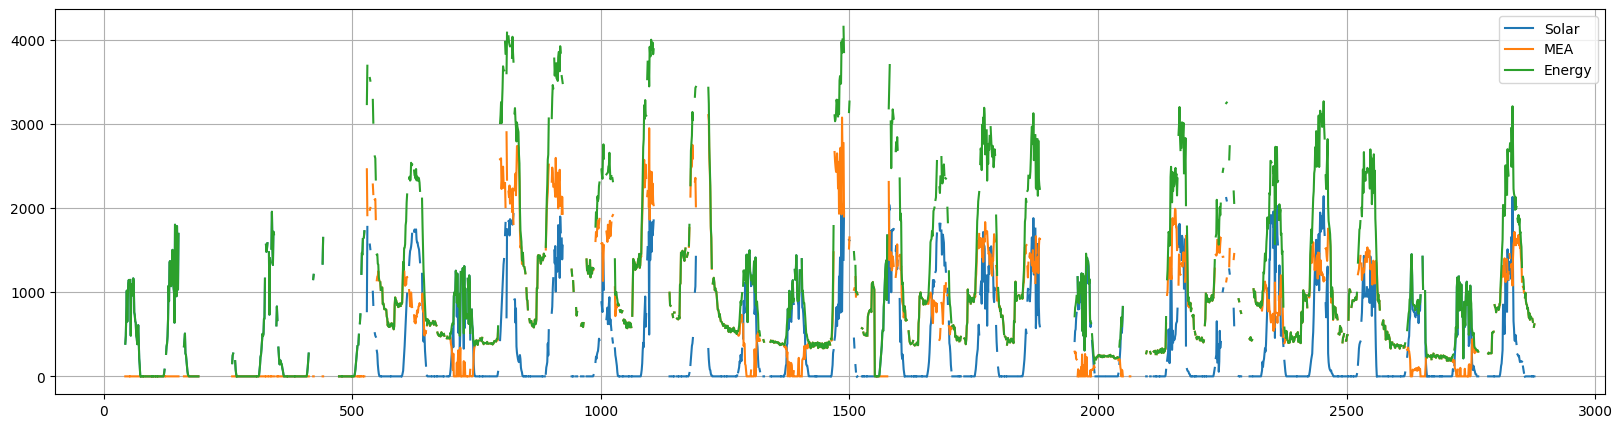

In [18]:
df_merged[['Solar', 'MEA', 'Energy']].plot(figsize=(20,5),
                                    grid= True)

## data imputation

### interpolation: linear

In [19]:
df_merged['Energy_linear'] = df_merged['Energy'].interpolate(method='linear')

<Axes: >

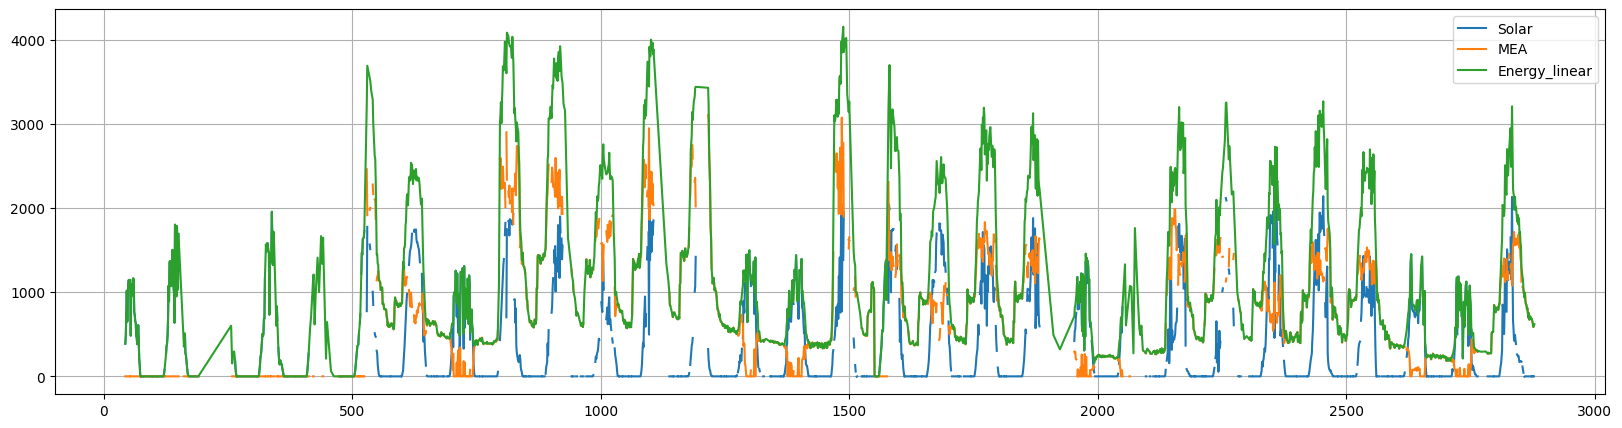

In [20]:
df_merged[['Solar', 'MEA', 'Energy_linear']].plot(figsize=(20,5),
                                    grid= True)


### interpolation: quadratic

<Axes: >

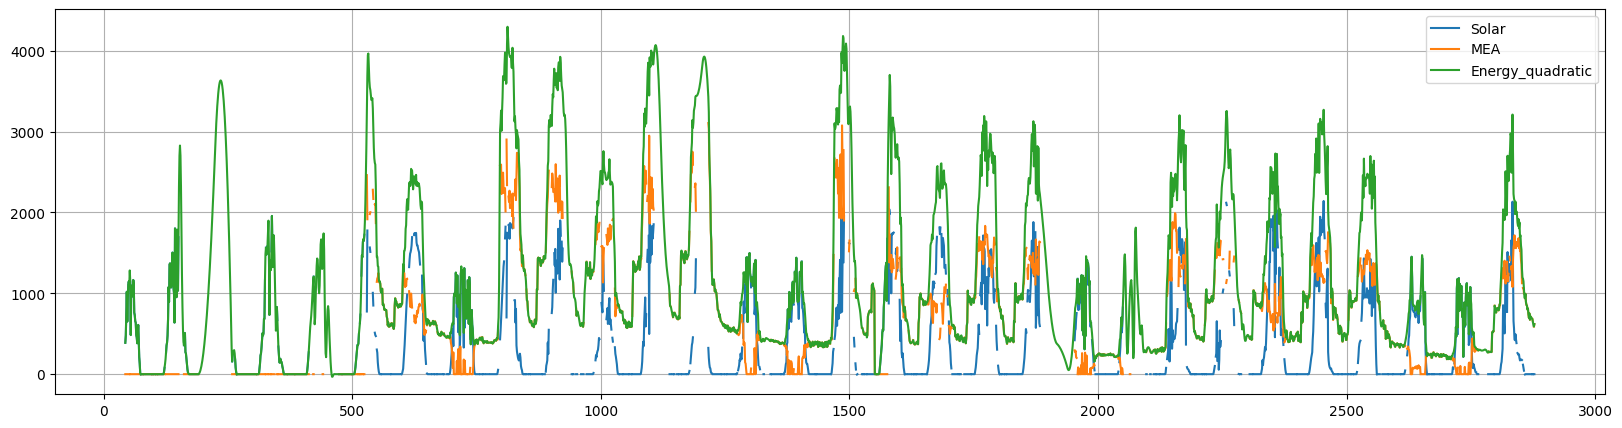

In [21]:
df_merged['Energy_quadratic'] = df_merged['Energy'].interpolate(method='quadratic')
df_merged[['Solar', 'MEA', 'Energy_quadratic']].plot(figsize=(20,5),
                                    grid= True)

### interpolation: cubic

<Axes: >

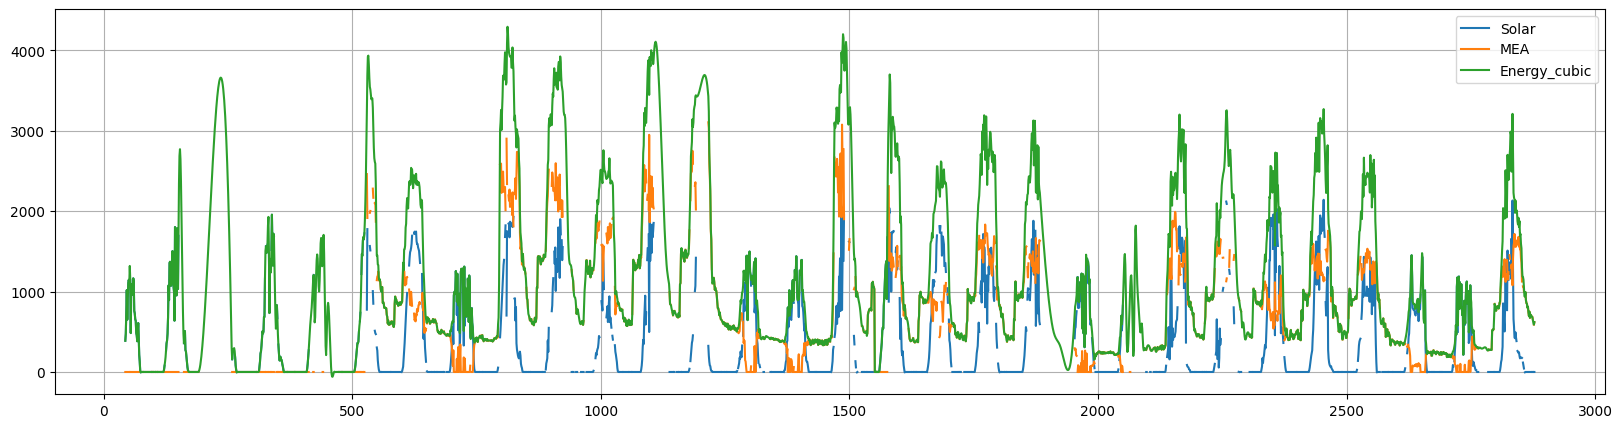

In [22]:
df_merged['Energy_cubic'] = df_merged['Energy'].interpolate(method='cubic')
df_merged[['Solar', 'MEA', 'Energy_cubic']].plot(figsize=(20,5),
                                    grid= True)

### mean: 'day_name','time'

<Axes: >

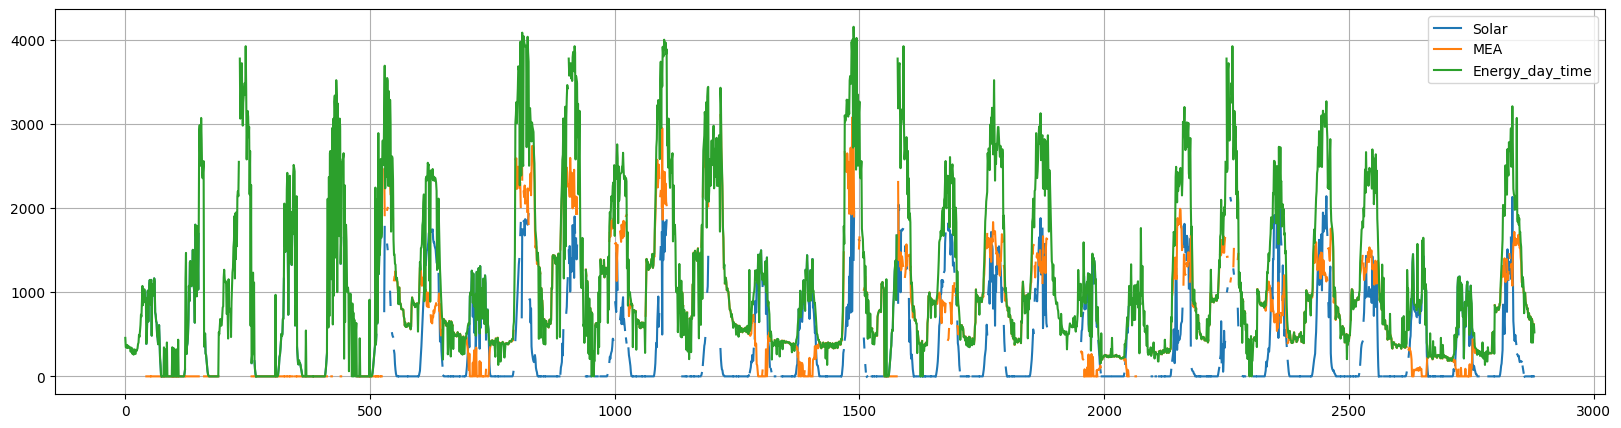

In [23]:
df_merged['day_name'] = df_merged['DateTime'].dt.day_name()
df_merged['time'] = df_merged['DateTime'].dt.time
group_means = df_merged.groupby(['day_name','time'])['Energy'].transform('mean')
df_merged['Energy_day_time'] = df_merged['Energy'].fillna(group_means)

df_merged[['Solar', 'MEA', 'Energy_day_time']].plot(figsize=(20,5),
                                    grid= True)

<Axes: >

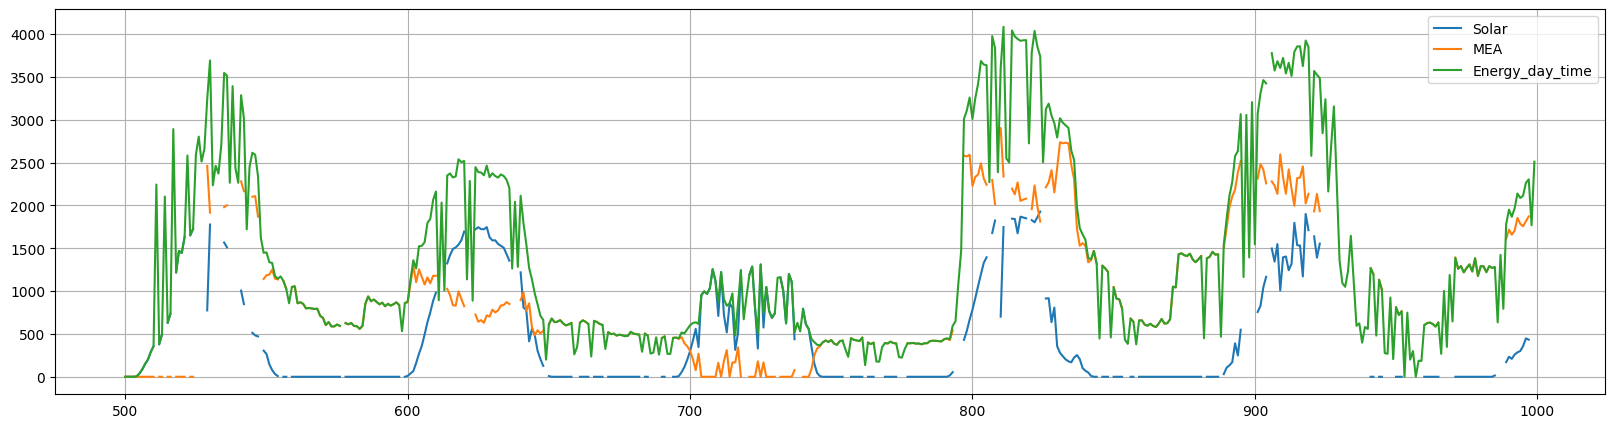

In [24]:
df_merged[['Solar', 'MEA', 'Energy_day_time']].iloc[500:1000].plot(figsize=(20,5),
                                    grid= True)

### mean: 'day_name','hour'

<Axes: >

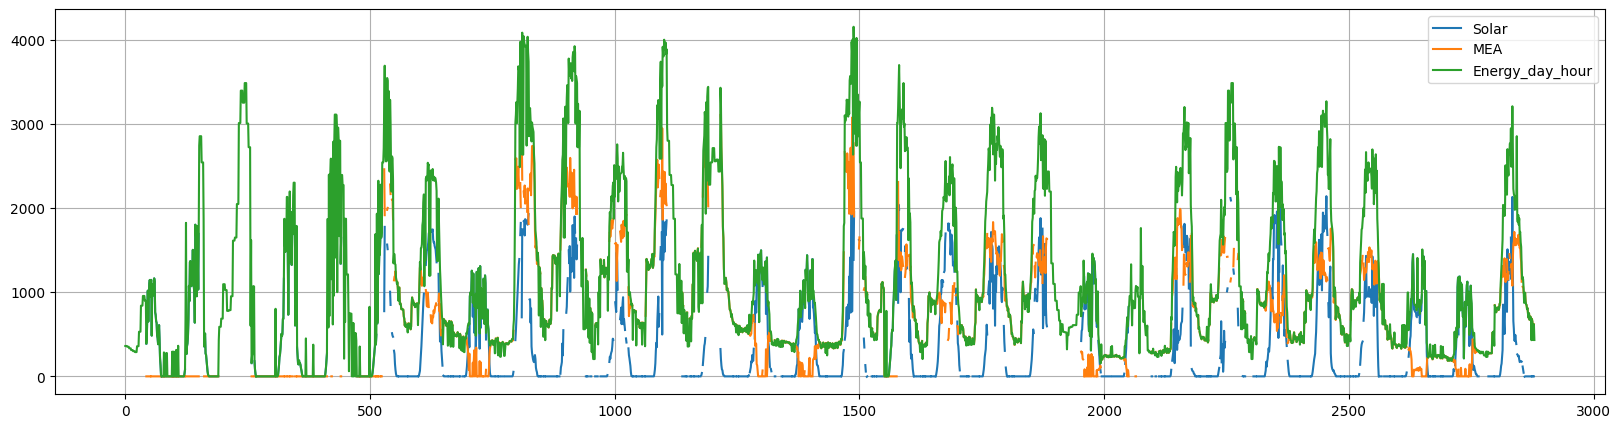

In [25]:
df_merged['day_name'] = df_merged['DateTime'].dt.day_name()
df_merged['hour'] = df_merged['DateTime'].dt.hour
group_means = df_merged.groupby(['day_name','hour'])['Energy'].transform('mean')
df_merged['Energy_day_hour'] = df_merged['Energy'].fillna(group_means)

df_merged[['Solar', 'MEA', 'Energy_day_hour']].plot(figsize=(20,5),
                                    grid= True)

In [26]:
df_merged

,DateTime,Solar,MEA,Energy,is_wfh,is_weekend,is_holiday,Energy_linear,Energy_quadratic,Energy_cubic,day_name,time,Energy_day_time,hour,Energy_day_hour
0,2025-06-01 00:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:00:00,457.500000,0,360.928571
1,2025-06-01 00:15:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:15:00,346.250000,0,360.928571
2,2025-06-01 00:30:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:30:00,347.500000,0,360.928571
3,2025-06-01 00:45:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:45:00,340.750000,0,360.928571
4,2025-06-01 01:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,01:00:00,373.333333,1,351.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0,0,0,0,647.0,647.000000,647.000000,Monday,22:45:00,647.000000,22,647.000000
2876,2025-06-30 23:00:00,NaN,NaN,NaN,0,0,0,618.0,606.823048,607.265619,Monday,23:00:00,401.000000,23,432.062500
2877,2025-06-30 23:15:00,0.0,589.0,589.0,0,0,0,589.0,589.000000,589.000000,Monday,23:15:00,589.000000,23,589.000000
2878,2025-06-30 23:30:00,0.0,619.0,619.0,0,0,0,619.0,619.000000,619.000000,Monday,23:30:00,619.000000,23,619.000000


### KNN

In [27]:
# Features: Energy + covariates 
df_KNN = df_merged.copy()
df_KNN['hour'] = df_KNN['DateTime'].dt.hour
df_KNN['dow'] = df_KNN['DateTime'].dt.dayofweek

In [28]:
df_KNN

,DateTime,Solar,MEA,Energy,is_wfh,is_weekend,is_holiday,Energy_linear,Energy_quadratic,Energy_cubic,day_name,time,Energy_day_time,hour,Energy_day_hour,dow
0,2025-06-01 00:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:00:00,457.500000,0,360.928571,6
1,2025-06-01 00:15:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:15:00,346.250000,0,360.928571,6
2,2025-06-01 00:30:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:30:00,347.500000,0,360.928571,6
3,2025-06-01 00:45:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:45:00,340.750000,0,360.928571,6
4,2025-06-01 01:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,01:00:00,373.333333,1,351.733333,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0,0,0,0,647.0,647.000000,647.000000,Monday,22:45:00,647.000000,22,647.000000,0
2876,2025-06-30 23:00:00,NaN,NaN,NaN,0,0,0,618.0,606.823048,607.265619,Monday,23:00:00,401.000000,23,432.062500,0
2877,2025-06-30 23:15:00,0.0,589.0,589.0,0,0,0,589.0,589.000000,589.000000,Monday,23:15:00,589.000000,23,589.000000,0
2878,2025-06-30 23:30:00,0.0,619.0,619.0,0,0,0,619.0,619.000000,619.000000,Monday,23:30:00,619.000000,23,619.000000,0


In [29]:
features = ['hour', 'dow', 'Solar','Energy']
imputer = KNNImputer(n_neighbors=5, weights="distance")

df_imputed = pd.DataFrame(imputer.fit_transform(df_KNN[features]), 
                          columns=features, index=df_KNN.index)

df_KNN['Energy_imputed_knn'] = df_imputed['Energy']

<Axes: >

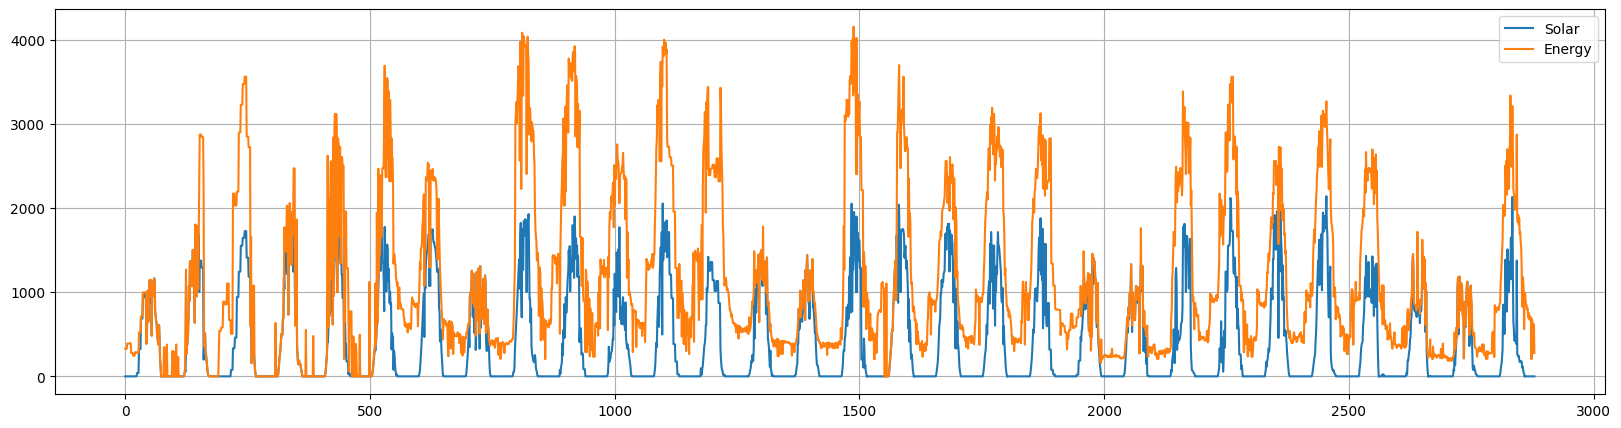

In [30]:
df_imputed[['Solar', 'Energy']].plot(figsize=(20,5),
                                    grid= True)

In [31]:
df_imputed

,hour,dow,Solar,Energy
0,0.0,6.0,0.0,327.6
1,0.0,6.0,0.0,327.6
2,0.0,6.0,0.0,327.6
3,0.0,6.0,0.0,327.6
4,1.0,6.0,0.0,390.4
...,...,...,...,...
2875,22.0,0.0,0.0,647.0
2876,23.0,0.0,0.0,279.6
2877,23.0,0.0,0.0,589.0
2878,23.0,0.0,0.0,619.0


<Axes: >

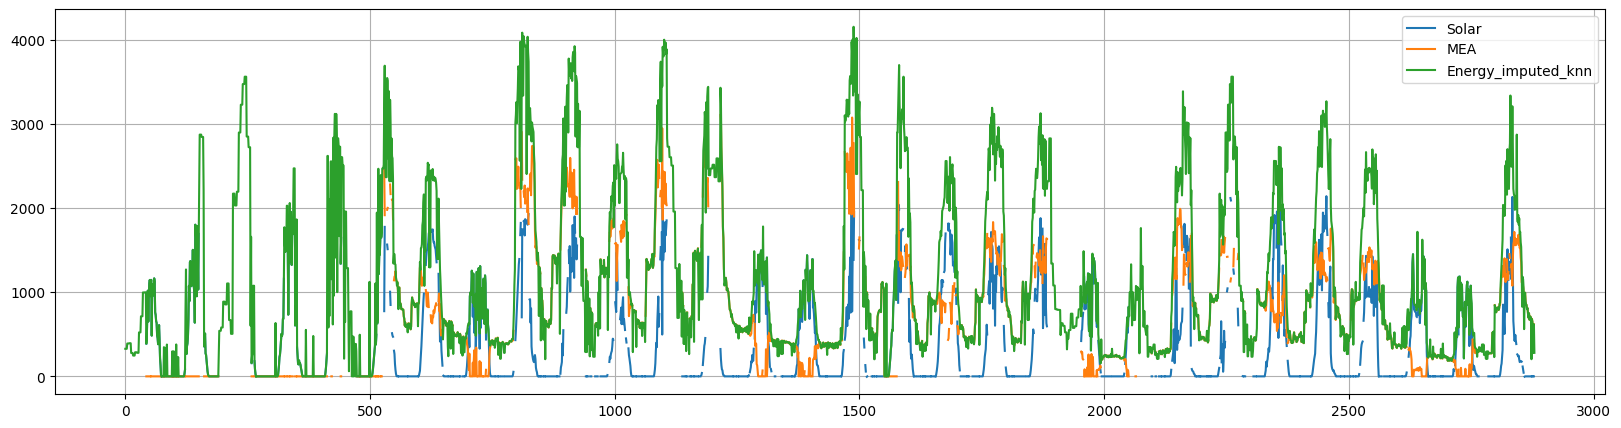

In [32]:
df_KNN[['Solar', 'MEA', 'Energy_imputed_knn']].plot(figsize=(20,5),
                                    grid= True)

In [33]:
df_KNN

,DateTime,Solar,MEA,Energy,is_wfh,is_weekend,is_holiday,Energy_linear,Energy_quadratic,Energy_cubic,day_name,time,Energy_day_time,hour,Energy_day_hour,dow,Energy_imputed_knn
0,2025-06-01 00:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:00:00,457.500000,0,360.928571,6,327.6
1,2025-06-01 00:15:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:15:00,346.250000,0,360.928571,6,327.6
2,2025-06-01 00:30:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:30:00,347.500000,0,360.928571,6,327.6
3,2025-06-01 00:45:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:45:00,340.750000,0,360.928571,6,327.6
4,2025-06-01 01:00:00,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,01:00:00,373.333333,1,351.733333,6,390.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0,0,0,0,647.0,647.000000,647.000000,Monday,22:45:00,647.000000,22,647.000000,0,647.0
2876,2025-06-30 23:00:00,NaN,NaN,NaN,0,0,0,618.0,606.823048,607.265619,Monday,23:00:00,401.000000,23,432.062500,0,279.6
2877,2025-06-30 23:15:00,0.0,589.0,589.0,0,0,0,589.0,589.000000,589.000000,Monday,23:15:00,589.000000,23,589.000000,0,589.0
2878,2025-06-30 23:30:00,0.0,619.0,619.0,0,0,0,619.0,619.000000,619.000000,Monday,23:30:00,619.000000,23,619.000000,0,619.0


### Random Forest

In [34]:
df_RF = df_merged.copy()
df_RF['hour'] = df_RF['DateTime'].dt.hour
df_RF['dow'] = df_RF['DateTime'].dt.dayofweek

In [35]:
df_RF.isna().sum()

DateTime              0
Solar               722
MEA                 720
Energy              722
is_wfh                0
is_weekend            0
is_holiday            0
Energy_linear        43
Energy_quadratic     44
Energy_cubic         44
day_name              0
time                  0
Energy_day_time      12
hour                  0
Energy_day_hour       0
dow                   0
dtype: int64

In [36]:
df_RF['Solar'] = df_imputed['Solar']

In [37]:
df_RF.isna().sum()

DateTime              0
Solar                 0
MEA                 720
Energy              722
is_wfh                0
is_weekend            0
is_holiday            0
Energy_linear        43
Energy_quadratic     44
Energy_cubic         44
day_name              0
time                  0
Energy_day_time      12
hour                  0
Energy_day_hour       0
dow                   0
dtype: int64

In [38]:
# Mask missing
train = df_RF.dropna(subset=['Energy'])
test = df_RF[df_RF['Energy'].isna()]

In [39]:
# Mask missing
train = df_RF.dropna(subset=['Energy'])
test = df_RF[df_RF['Energy'].isna()]

X_train = train[['Solar', 'hour', 'dow']]
y_train = train['Energy']

X_test = test[['Solar', 'hour', 'dow']]

# Train RF
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict missing
df_RF['Energy_imputed_rf'] = df_RF['Energy'].copy()
df_RF.loc[df_RF['Energy_imputed_rf'].isna(), 'Energy_imputed_rf'] = rf.predict(X_test)

In [40]:
df_RF['Energy_imputed_knn'] = df_KNN['Energy_imputed_knn']

<Axes: >

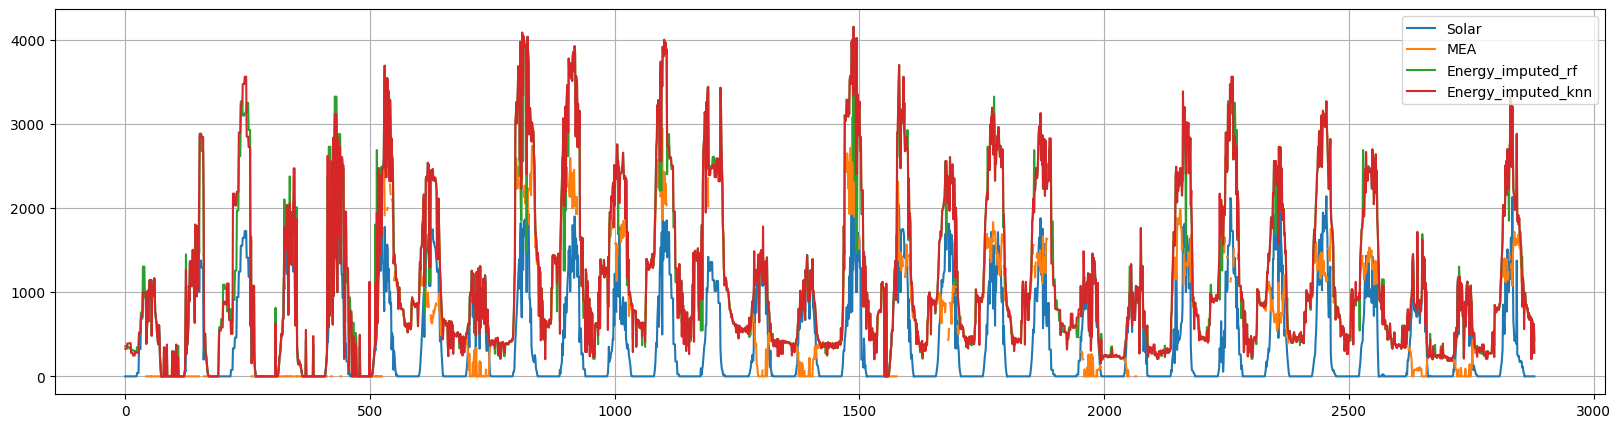

In [41]:
df_RF[['Solar', 'MEA', 'Energy_imputed_rf','Energy_imputed_knn']].plot(figsize=(20,5),
                                    grid= True)

In [42]:
df_RF

,DateTime,Solar,MEA,Energy,is_wfh,is_weekend,is_holiday,Energy_linear,Energy_quadratic,Energy_cubic,day_name,time,Energy_day_time,hour,Energy_day_hour,dow,Energy_imputed_rf,Energy_imputed_knn
0,2025-06-01 00:00:00,0.0,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:00:00,457.500000,0,360.928571,6,357.829977,327.6
1,2025-06-01 00:15:00,0.0,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:15:00,346.250000,0,360.928571,6,357.829977,327.6
2,2025-06-01 00:30:00,0.0,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:30:00,347.500000,0,360.928571,6,357.829977,327.6
3,2025-06-01 00:45:00,0.0,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,00:45:00,340.750000,0,360.928571,6,357.829977,327.6
4,2025-06-01 01:00:00,0.0,NaN,NaN,0,1,0,NaN,NaN,NaN,Sunday,01:00:00,373.333333,1,351.733333,6,352.306129,390.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2025-06-30 22:45:00,0.0,647.0,647.0,0,0,0,647.0,647.000000,647.000000,Monday,22:45:00,647.000000,22,647.000000,0,647.000000,647.0
2876,2025-06-30 23:00:00,0.0,NaN,NaN,0,0,0,618.0,606.823048,607.265619,Monday,23:00:00,401.000000,23,432.062500,0,429.518117,279.6
2877,2025-06-30 23:15:00,0.0,589.0,589.0,0,0,0,589.0,589.000000,589.000000,Monday,23:15:00,589.000000,23,589.000000,0,589.000000,589.0
2878,2025-06-30 23:30:00,0.0,619.0,619.0,0,0,0,619.0,619.000000,619.000000,Monday,23:30:00,619.000000,23,619.000000,0,619.000000,619.0


## filter function

In [43]:
# Split into two DataFrames based on time range
df_daytime = df[(df['DateTime'].dt.time >= pd.to_datetime('06:00:00').time()) & 
                (df['DateTime'].dt.time < pd.to_datetime('18:00:00').time())]

df_nighttime = df[(df['DateTime'].dt.time >= pd.to_datetime('18:00:00').time()) | 
                  (df['DateTime'].dt.time < pd.to_datetime('06:00:00').time())]

# Display or save the results
print("Daytime DataFrame:")
print(df_daytime)

print("\nNighttime DataFrame:")
print(df_nighttime)


Daytime DataFrame:
0               DateTime   Solar   MEA  Energy YearMonth
1    2025-06-01 10:45:00   388.0     0   388.0   2025-06
2    2025-06-01 11:00:00   478.0     0   478.0   2025-06
3    2025-06-01 11:15:00   767.0     0   767.0   2025-06
4    2025-06-01 11:30:00  1019.0     0  1019.0   2025-06
5    2025-06-01 11:45:00   651.0     0   651.0   2025-06
...                  ...     ...   ...     ...       ...
2136 2025-06-30 16:30:00   176.0  1542  1718.0   2025-06
2137 2025-06-30 16:45:00   180.0  1414  1594.0   2025-06
2138 2025-06-30 17:00:00   181.0  1358  1539.0   2025-06
2139 2025-06-30 17:15:00   175.0  1125  1300.0   2025-06
2140 2025-06-30 17:45:00   117.0  1066  1183.0   2025-06

[1060 rows x 5 columns]

Nighttime DataFrame:
0               DateTime  Solar  MEA  Energy YearMonth
29   2025-06-01 18:00:00  132.0    0   132.0   2025-06
30   2025-06-01 18:15:00   14.0    0    14.0   2025-06
31   2025-06-01 18:30:00   -5.0    0    -5.0   2025-06
32   2025-06-01 18:45:00    0.

In [44]:
# Calculate mean and standard deviation
mean_day = np.mean(df_daytime['Energy'])
std_day = np.std(df_daytime['Energy'])

mean_night = np.mean(df_nighttime['Energy'])
std_night = np.std(df_nighttime['Energy'])

print(f'mean_day = {mean_day:.3f}')
print(f'mean_night = {mean_night:.3f}')
print(f'std_day = {std_day:.3f}')
print(f'std_night = {std_night:.3f}')

mean_day = 1703.212
mean_night = 517.308
std_day = 1010.154
std_night = 373.938


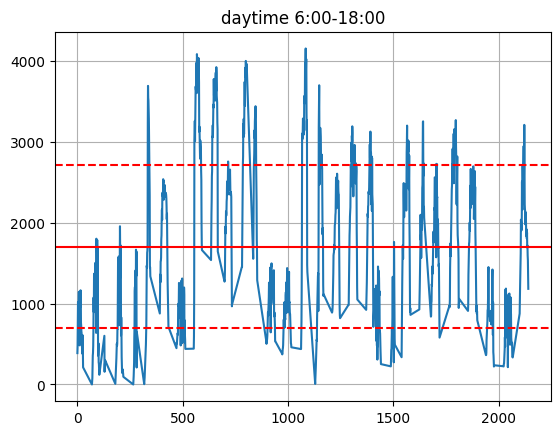

In [45]:
plt.plot(df_daytime['Energy'])
plt.axhline(mean_day, c='r')
plt.axhline(mean_day+std_day, c='r', ls='--')
plt.axhline(mean_day-std_day, c='r', ls='--')
plt.title('daytime 6:00-18:00')
plt.grid(True)

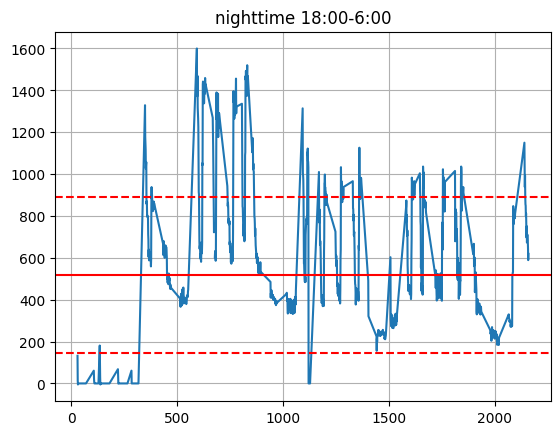

In [46]:
plt.plot(df_nighttime['Energy'])
plt.axhline(mean_night, c='r')
plt.axhline(mean_night+std_night, c='r', ls='--')
plt.axhline(mean_night-std_night, c='r', ls='--')
plt.title('nighttime 18:00-6:00')
plt.grid(True)

In [47]:
# Assign mean_Energy based on time
def assign_mean_energy(dt):
    time = dt.time()
    if pd.to_datetime('06:00:00').time() <= time < pd.to_datetime('18:00:00').time():
        return mean_day
    else:
        return mean_night

df['Mean_Energy'] = df['DateTime'].apply(assign_mean_energy)

# Display the updated DataFrame
df[['DateTime', 'Energy', 'Mean_Energy']]


,DateTime,Energy,Mean_Energy
1,2025-06-01 10:45:00,388.0,1703.212465
2,2025-06-01 11:00:00,478.0,1703.212465
3,2025-06-01 11:15:00,767.0,1703.212465
4,2025-06-01 11:30:00,1019.0,1703.212465
5,2025-06-01 11:45:00,651.0,1703.212465
...,...,...,...
2156,2025-06-30 22:00:00,695.0,517.307552
2157,2025-06-30 22:30:00,681.0,517.307552
2158,2025-06-30 22:45:00,647.0,517.307552
2159,2025-06-30 23:15:00,589.0,517.307552


<Axes: title={'center': 'energy with mean corresponding to night & day shift'}, xlabel='Time index', ylabel='Power (kW)'>

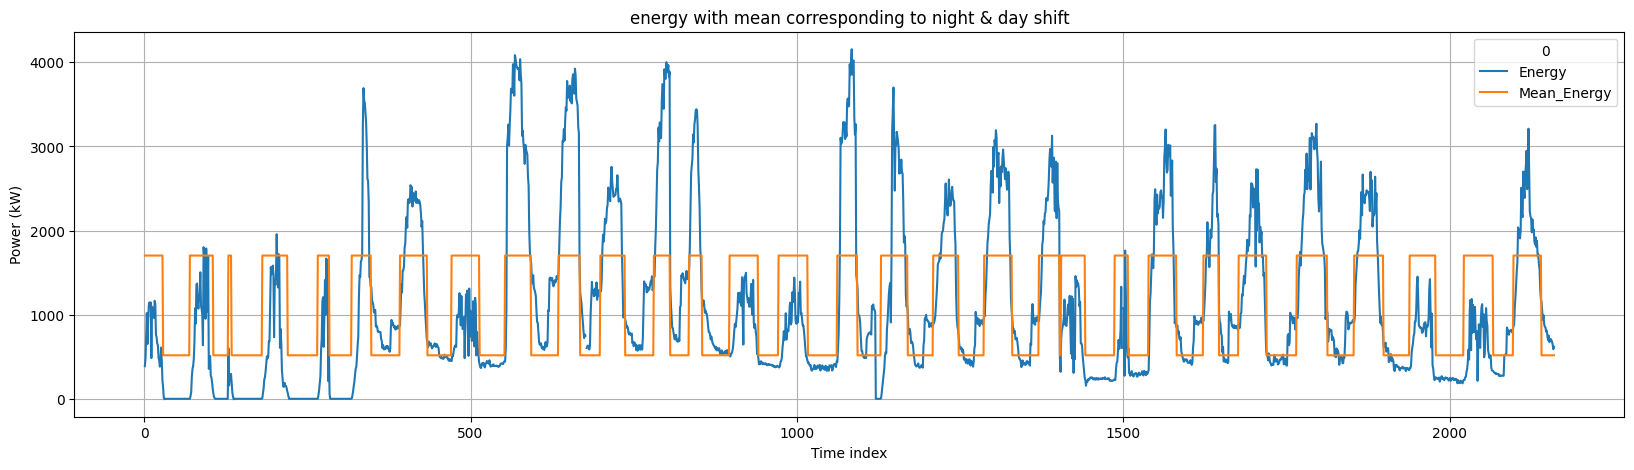

In [48]:
df[['Energy', 'Mean_Energy']].plot(figsize=(20,5),
                                   title= 'energy with mean corresponding to night & day shift',
                                   ylabel= 'Power (kW)',
                                   xlabel= 'Time index',
                                   grid= True)

In [49]:
np.std(df_daytime['Energy'])

1010.1544068041774

In [50]:
np.mean(df_daytime['Energy'])

1703.2124645892352

In [51]:
df['Lower_Bound'] = np.where(
    (df['DateTime'].dt.time >= pd.to_datetime('06:00:00').time()) & 
    (df['DateTime'].dt.time < pd.to_datetime('18:00:00').time()),
    mean_day - std_day,
    mean_night - std_night
)

df['Upper_Bound'] = np.where(
    (df['DateTime'].dt.time >= pd.to_datetime('06:00:00').time()) & 
    (df['DateTime'].dt.time < pd.to_datetime('18:00:00').time()),
    mean_day + std_day,
    mean_night + std_night
)

In [52]:
df[['DateTime', 'Energy', 'Mean_Energy', 'Lower_Bound', 'Upper_Bound']].head()

,DateTime,Energy,Mean_Energy,Lower_Bound,Upper_Bound
1,2025-06-01 10:45:00,388.0,1703.212465,693.058058,2713.366871
2,2025-06-01 11:00:00,478.0,1703.212465,693.058058,2713.366871
3,2025-06-01 11:15:00,767.0,1703.212465,693.058058,2713.366871
4,2025-06-01 11:30:00,1019.0,1703.212465,693.058058,2713.366871
5,2025-06-01 11:45:00,651.0,1703.212465,693.058058,2713.366871


<Axes: title={'center': 'energy with mean corresponding to night & day shift'}, xlabel='Time index', ylabel='Power (kW)'>

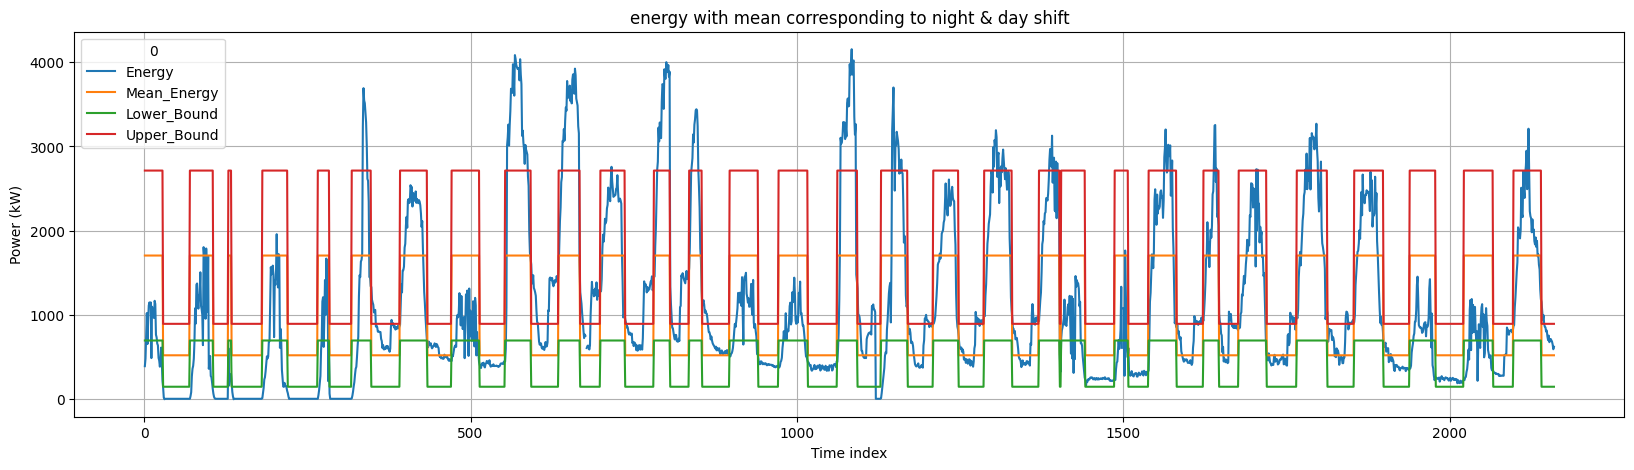

In [53]:
df[['Energy', 'Mean_Energy', 'Lower_Bound', 'Upper_Bound']].plot(figsize=(20,5),
                                   title= 'energy with mean corresponding to night & day shift',
                                   ylabel= 'Power (kW)',
                                   xlabel= 'Time index',
                                   grid= True)